# <!-- TITLE --> [IMDB1] - Sentiment analysis with hot-one encoding
<!-- DESC --> A basic example of sentiment analysis with sparse encoding, using a dataset from Internet Movie Database (IMDB)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Understand the management of **textual data** and **sentiment analysis**

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result

Step 1 - Import and init
1.1 - Python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

import os,sys,h5py,json
from importlib import reload

run_dir = './run/IMDB1'

### 1.2 - Parameters
The words in the vocabulary are classified from the most frequent to the rarest.\
`vocab_size` is the number of words we will remember in our vocabulary (the other words will be considered as unknown).\
`hide_most_frequently` is the number of ignored words, among the most common ones\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [2]:
vocab_size           = 10000
hide_most_frequently = 0

epochs               = 30
batch_size           = 512
fit_verbosity        = 1

## Step 2 - Understanding hot-one encoding
#### We have a **sentence** and a **dictionary** :

In [3]:
sentence = "I've never seen a movie like this before"

dictionary  = {"a":0, "before":1, "fantastic":2, "i've":3, "is":4, "like":5, "movie":6, "never":7, "seen":8, "this":9}

#### We encode our sentence as a **numerical vector** :

In [4]:
sentence_words = sentence.lower().split()

sentence_vect  = [ dictionary[w] for w in sentence_words ]

print('Words sentence are         : ', sentence_words)
print('Our vectorized sentence is : ', sentence_vect)

Words sentence are         :  ["i've", 'never', 'seen', 'a', 'movie', 'like', 'this', 'before']
Our vectorized sentence is :  [3, 7, 8, 0, 6, 5, 9, 1]


#### Next, we **one-hot** encode our vectorized sentence as a tensor :

In [5]:
# ---- We get a (sentence length x vector size) matrix of zeros
#
onehot = np.zeros( (10,8) )

# ---- We set some 1 for each word
#
for i,w in enumerate(sentence_vect):
    onehot[w,i]=1

# --- Show it
#
print('In a basic way :\n\n', onehot, '\n\nWith a pandas wiew :\n')
data={ f'{sentence_words[i]:.^10}':onehot[:,i] for i,w in enumerate(sentence_vect) }
df=pd.DataFrame(data)
df.index=dictionary.keys()
df.style.set_precision(0).highlight_max(axis=0).set_properties(**{'text-align': 'center'})

In a basic way :

 [[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]] 

With a pandas wiew :



C:\Users\Massimo\AppData\Local\Temp/ipykernel_1760/1247172091.py:16: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.style.set_precision(0).highlight_max(axis=0).set_properties(**{'text-align': 'center'})


,...i've...,..never...,...seen...,....a.....,..movie...,...like...,...this...,..before..
a,0,0,0,1,0,0,0,0
before,0,0,0,0,0,0,0,1
fantastic,0,0,0,0,0,0,0,0
i've,1,0,0,0,0,0,0,0
is,0,0,0,0,0,0,0,0
like,0,0,0,0,0,1,0,0
movie,0,0,0,0,1,0,0,0
never,0,1,0,0,0,0,0,0
seen,0,0,1,0,0,0,0,0
this,0,0,0,0,0,0,1,0


## Step 3 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

### 3.1 - Data structure :  
The dataset is composed of 2 parts: 

 - **reviews**, this will be our **x**
 - **opinions** (positive/negative), this will be our **y**

There are also a **dictionary**, because words are indexed in reviews

```
<dataset> = (<reviews>, <opinions>)

with :  <reviews>  = [ <review1>, <review2>, ... ]
        <opinions> = [ <rate1>,   <rate2>,   ... ]   where <ratei>   = integer

where : <reviewi> = [ <w1>, <w2>, ...]    <wi> are the index (int) of the word in the dictionary
        <ratei>   = int                   0 for negative opinion, 1 for positive


<dictionary> = [ <word1>:<w1>, <word2>:<w2>, ... ]

with :  <wordi>   = word
        <wi>      = int

```

### 3.2 - Load dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

By default : 
 - Start of a sequence will be marked with : 1
 - Out of vocabulary word will be : 2
 - First index will be : 3

In [6]:
# ----- Retrieve x,y
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=vocab_size, skip_top=hide_most_frequently)

In [7]:
# ---- About
#

y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)


## Step 4 - About our dataset
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

### 4.1 - Sentences encoding

In [8]:
print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nOpinions (y_train) :\n\n',y_train)


Review example (x_train[12]) :

 [1, 13, 119, 954, 189, 1554, 13, 92, 459, 48, 4, 116, 9, 1492, 2291, 42, 726, 4, 1939, 168, 2031, 13, 423, 14, 20, 549, 18, 4, 2, 547, 32, 4, 96, 39, 4, 454, 7, 4, 22, 8, 4, 55, 130, 168, 13, 92, 359, 6, 158, 1511, 2, 42, 6, 1913, 19, 194, 4455, 4121, 6, 114, 8, 72, 21, 465, 9667, 304, 4, 51, 9, 14, 20, 44, 155, 8, 6, 226, 162, 616, 651, 51, 9, 14, 20, 44, 10, 10, 14, 218, 4843, 629, 42, 3017, 21, 48, 25, 28, 35, 534, 5, 6, 320, 8, 516, 5, 42, 25, 181, 8, 130, 56, 547, 3571, 5, 1471, 851, 14, 2286]

Opinions (y_train) :

 [1. 0. 0. ... 0. 1. 0.]


### 4.2 - Load dictionary


In [9]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}


# ---- Add <pad>, <start> and <unknown> tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- About dictionary
#
print('\nDictionary size     : ', len(word_index))
print('\nSmall extract :\n')
for k in range(0,20):print(f'    {k:2d} : {index_word[k]}' )


Dictionary size     :  88588

Small extract :

     0 : <pad>
     1 : <start>
     2 : <unknown>
     3 : <undef>
     4 : the
     5 : and
     6 : a
     7 : of
     8 : to
     9 : is
    10 : br
    11 : in
    12 : it
    13 : i
    14 : this
    15 : that
    16 : was
    17 : as
    18 : for
    19 : with


In [10]:
# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

In [1]:
myDict = ["name", "John", "country", "Norway"]
mySeparator = " "

x = mySeparator.join(myDict)

print(x)

name John country Norway


In [12]:
def dataset2text2(review):
    a=[index_word.get(i) for i in review]
    mySeparator = '  '
    return mySeparator.join(a)

In [13]:
print(dataset2text2(x_train[12]))

<start>  i  love  cheesy  horror  flicks  i  don't  care  if  the  acting  is  sub  par  or  whether  the  monsters  look  corny  i  liked  this  movie  except  for  the  <unknown>  feeling  all  the  way  from  the  beginning  of  the  film  to  the  very  end  look  i  don't  need  a  10  page  <unknown>  or  a  sign  with  big  letters  explaining  a  plot  to  me  but  dark  floors  takes  the  what  is  this  movie  about  thing  to  a  whole  new  annoying  level  what  is  this  movie  about  br  br  this  isn't  exceptionally  scary  or  thrilling  but  if  you  have  an  hour  and  a  half  to  kill  and  or  you  want  to  end  up  feeling  frustrated  and  confused  rent  this  winner


### 4.3 - Have a look, for human

In [2]:
from IPython.display import Markdown
def subtitle(t):
    display(Markdown(f'<br>**{t}**'))

subtitle('Review example :')
print(x_train[12])
subtitle('After translation :')
print(dataset2text(x_train[12]))

<br>**Review example :**

NameError: name 'x_train' is not defined

### 4.4 - Few statistics

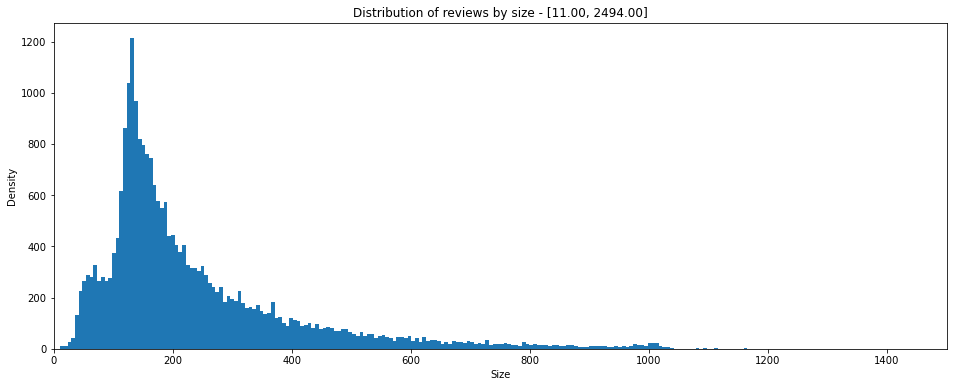

In [15]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])
plt.show()

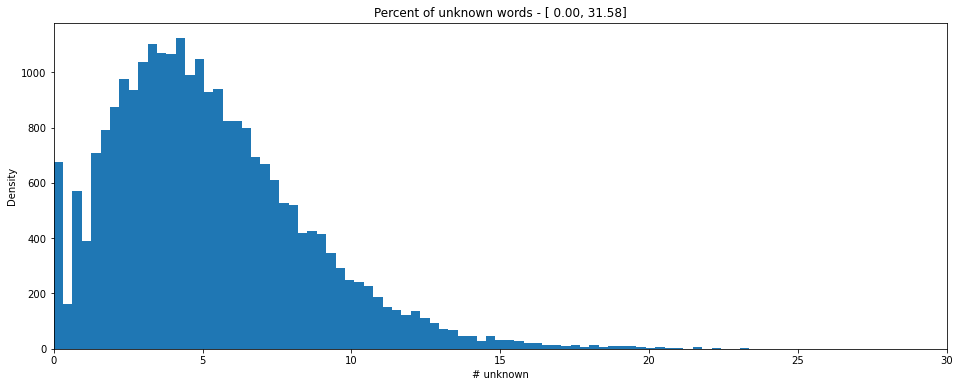

In [16]:
unk=[ 100*(s.count(2)/len(s)) for s in x_train] #count(2) car 2 : <unknown>
plt.figure(figsize=(16,6))
plt.hist(unk, bins=100)
plt.gca().set(title='Percent of unknown words - [{:5.2f}, {:5.2f}]'.format(min(unk),max(unk)), 
              xlabel='# unknown', ylabel='Density', xlim=[0,30])
plt.show()

## Step 5 - Basic approach with "one-hot" vector encoding
Basic approach.  

Each sentence is encoded with a **vector** of length equal to the **size of the dictionary**.   

Each sentence will therefore be encoded with a simple vector.  
The value of each component is 0 if the word is not present in the sentence or 1 if the word is present.

For a sentence s=[3,4,7] and a dictionary of 10 words...    
We wil have a vector v=[0,0,0,1,1,0,0,1,0,0,0]

### 5.1 - Our one-hot encoder

In [17]:
def one_hot_encoder(x, vector_size=10000):
    
    # ---- Set all to 0
    #
    x_encoded = np.zeros((len(x), vector_size))
    
    # ---- For each sentence
    #
    for i,sentence in enumerate(x):
        for word in sentence:
            x_encoded[i, word] = 1.

    return x_encoded

### 5.2 - Encoding..

In [18]:
x_train = one_hot_encoder(x_train)
x_test  = one_hot_encoder(x_test)

print("To have a look, x_train[12] became :", x_train[12] )

To have a look, x_train[12] became : [0. 1. 1. ... 0. 0. 0.]


## Step 6 - Build the model

In [19]:
def get_model(vector_size=10000):
    
    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(vector_size,) ))
    model.add(keras.layers.Dense( 32, activation='relu'))
    model.add(keras.layers.Dense( 64, activation='relu'))
    model.add(keras.layers.Dense( 128, activation='relu'))
    model.add(keras.layers.Dense( 1, activation='sigmoid'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 7 - Train the model
### 7.1 - Get it

In [20]:
model = get_model(vector_size=vocab_size)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 330,593
Trainable params: 330,593
Non-trainable params: 0
_________________________________________________________________


### 7.2 - Add callback

In [21]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 7.3 - Train it

In [22]:
history = model.fit(x_train,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])

Epoch 1/30
49/49 [==============================] - 2s 38ms/step - loss: 0.4326 - accuracy: 0.8067 - val_loss: 0.3418 - val_accuracy: 0.8572
Epoch 2/30
49/49 [==============================] - 1s 26ms/step - loss: 0.2346 - accuracy: 0.9079 - val_loss: 0.3053 - val_accuracy: 0.8772
Epoch 3/30
49/49 [==============================] - 1s 26ms/step - loss: 0.1881 - accuracy: 0.9285 - val_loss: 0.3021 - val_accuracy: 0.8800
Epoch 4/30
49/49 [==============================] - 1s 26ms/step - loss: 0.1484 - accuracy: 0.9429 - val_loss: 0.3327 - val_accuracy: 0.8776
Epoch 5/30
49/49 [==============================] - 1s 24ms/step - loss: 0.1236 - accuracy: 0.9522 - val_loss: 0.3859 - val_accuracy: 0.8613
Epoch 6/30
49/49 [==============================] - 1s 25ms/step - loss: 0.0877 - accuracy: 0.9688 - val_loss: 0.4377 - val_accuracy: 0.8694
Epoch 7/30
49/49 [==============================] - 1s 25ms/step - loss: 0.0725 - accuracy: 0.9740 - val_loss: 0.4913 - val_accuracy: 0.8665
Epoch 8/30
49

## Step 8 - Evaluate
### 8.1 - Training history

In [23]:
df=pd.DataFrame(data=history.history)
display(df)

,loss,accuracy,val_loss,val_accuracy
0,0.432607,0.80672,0.341760,0.85720
1,0.234647,0.90792,0.305336,0.87720
2,0.188070,0.92852,0.302126,0.87996
3,0.148432,0.94288,0.332657,0.87760
4,0.123646,0.95220,0.385913,0.86128
5,0.087662,0.96880,0.437657,0.86936
6,0.072466,0.97396,0.491294,0.86652
7,0.059732,0.98092,0.855399,0.81780
8,0.044373,0.98676,0.627858,0.86364
9,0.036707,0.98952,0.694576,0.86160


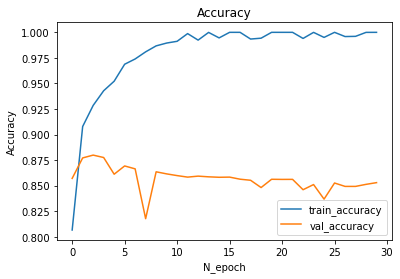

In [24]:
plt.figure()
plt.plot(df['accuracy'],label='train_accuracy')
plt.plot(df['val_accuracy'],label='val_accuracy')
plt.title("Accuracy")
plt.xlabel('N_epoch')
plt.ylabel('Accuracy')
plt.legend()

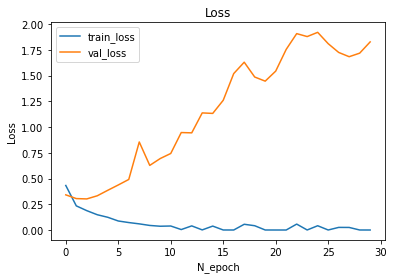

In [25]:
plt.figure()
plt.plot(df['loss'],label='train_loss')
plt.plot(df['val_loss'],label='val_loss')
plt.title("Loss")
plt.xlabel('N_epoch')
plt.ylabel('Loss')
plt.legend()

## Step 8 - Evaluate
### 8.1 - Training history

### 8.2 - Reload and evaluate best model

In [26]:
def plot_donut(values, labels, colors=["lightsteelblue","coral"], figsize=(6,6), title=None):
    """
    Draw a donut
    args:
        values   : list of values
        labels   : list of labels
        colors   : list of color (["lightsteelblue","coral"])
        figsize  : size of figure ( (6,6) )
    return:
        nothing
    """
    # ---- Title or not
    if title != None :  display(Markdown(title))
    # ---- Donut
    plt.figure(figsize=figsize)
    # ---- Draw a pie  chart..
    plt.pie(values, labels=labels, 
            colors = colors, autopct='%1.1f%%', startangle=70, pctdistance=0.85,
            textprops={'fontsize': 18},
            wedgeprops={"edgecolor":"w",'linewidth': 5, 'linestyle': 'solid', 'antialiased': True})
    # ---- ..with a white circle
    circle = plt.Circle((0,0),0.70,fc='white')
    ax = plt.gca()
    ax.add_artist(circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')  
    plt.tight_layout()
    plt.show()

x_test / loss      : 0.3021
x_test / accuracy  : 0.8800


#### Accuracy donut is :

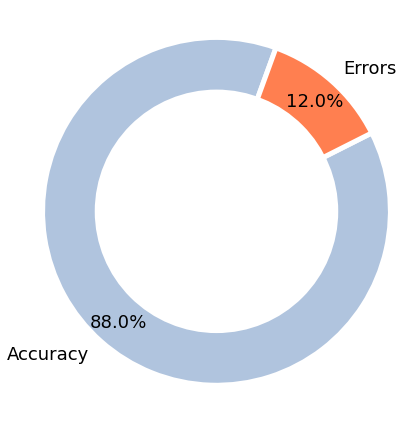

In [27]:
model = keras.models.load_model(f'{run_dir}/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :")

# ---- Confusion matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1  